<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Logistic Regression Practice


## Introduction
- Data from the UCI Machine Learning Repository: [bank data](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- **Goal**: Predict whether a customer will purchase a bank product marketed over the phone
- `bank.csv` is already in our repo, so there is no need to download the data from the UCI website

#### Read the data into Pandas

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

bank = pd.read_csv('../assets/data/bank.csv')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


#### 1: What is the distribution of our target?

In [2]:
bank['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

#### 2: You know the drill... explore the data!

- choose 3-4 features to put in your model
- do exploratory data analysis on those features

In [3]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Let's use age, marital status and job

In [4]:
features = ['age', 'job', 'marital']

for feat in features:
    if feat != 'age':
        print(bank[feat].value_counts())

admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: job, dtype: int64
married     2509
single      1153
divorced     446
unknown       11
Name: marital, dtype: int64


No "NULL" values but there are some "unknowns" which we should drop

In [5]:
bank = bank[(bank["job"] != "unknown") & (bank["marital"] != "unknown")]

Create dummies. Let's base the baseline on a married person working in an admin job.

In [6]:
X = pd.get_dummies(bank[features], columns=["job", "marital"], drop_first=False)
X.drop(["job_admin.", "marital_married"], axis=1, inplace=True)
y = bank["y"]

#### 3: Do a train-test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### 4: Fit a logistic regression model on your training set

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train);

#### 5: What is the interpretation of the coefficients?

If you used a categorical feature, calculate the log odds for the baseline, and the log odds for one of its other values.

What is the difference in log odds, and therefore the difference in probability?

In [9]:
for z in zip(lr.coef_.ravel(), X_train.columns):
    print(z)

(0.022416803132521236, 'age')
(-0.667617780395299, 'job_blue-collar')
(-0.7890707185341855, 'job_entrepreneur')
(-0.1170186625481678, 'job_housemaid')
(-0.2761586401857751, 'job_management')
(0.26626665649197323, 'job_retired')
(-0.24779428651947236, 'job_self-employed')
(-0.40967453526649966, 'job_services')
(0.7970071573165022, 'job_student')
(-0.14716488835948718, 'job_technician')
(0.20015046666420983, 'job_unemployed')
(-0.05807417049023293, 'marital_divorced')
(0.5201577712114884, 'marital_single')


Age seems to increase the probability only slightly, but what about the different jobs or marital statuses?

To test that, we need to use the linear equation and substitute a value for age. We'll use the mean.

In [10]:
import numpy as np

np.mean(X_train["age"])

39.92310393258427

Let's round to 40 and add it into the equation, and turn the log odds into a baseline probability

In [11]:
baseline_log_odds = lr.intercept_ + lr.coef_[0][0]*40

def log_odds_to_proba(log_odds):
    odds = np.exp(log_odds)
    prob = odds/(1+odds)
    return prob

log_odds_to_proba(baseline_log_odds)

array([0.11288862])

So a married 40-year old in an admin job is 11.3% likely to buy the product.

What if we now try adding the coefficient for "entrepreneur"?

In [12]:
log_odds_entrepreneur = lr.intercept_ + lr.coef_[0][0]*40 + lr.coef_[0][2]
log_odds_to_proba(log_odds_entrepreneur)

array([0.05464827])

The coefficient was negative, and for a 40-year old that means the probability has moved to just 5.5%.

What about someone who's single? We have a positive coefficient so we expect the probability to go up.

In [13]:
log_odds_single = lr.intercept_ + lr.coef_[0][0]*40 + lr.coef_[0][-1]
log_odds_to_proba(log_odds_single)

array([0.17633024])

As expected, that value has gone up to 17.6%.

Let's also check age for completeness. Let's reduce the age from 40 to 30 and see the effect.

In [14]:
log_odds_30 = lr.intercept_ + lr.coef_[0][0]*30
log_odds_to_proba(log_odds_30)

array([0.09231114])

As expected, because the coefficient is positive, reducing the age reduces the baseline probability. A married 30-year old in an admin job is only 9.2% likely to buy.

#### 6: BONUS - model improvement

Try some things to improve your score:

- Use more/fewer/different features
- Use grid search to find the right value of `C` for regularisation
    - You could also try both `l1` and `l2` regularisation
- Use cross-validation to evaluate the logistic regression model with your chosen features. Look at different metrics:
    - [Classification/Accuracy Error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
    - [The Confusion Matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
    - [Precision, recall, and area under a curve (AUC)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
- Obtain the test error using your best model

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# we'll use the area under the curve to find the "best" parameters
grid = GridSearchCV(LogisticRegression(),
                    param_grid={"penalty": ["l1", "l2"],
                                "C": np.logspace(-4, 2, 7)},
                    scoring="roc_auc",
                    cv=StratifiedKFold(10))

grid.fit(X_train, y_train);

In [16]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

Looks like regular Logistic Regression was the best!

In [17]:
grid.best_score_

0.6049714780380082

Verify performance

In [18]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(LogisticRegression(), X_train, y_train, scoring="roc_auc", cv=10))

0.6049440190221784

Do another train-test split so we can evaluate on a validation set without using `X_test`

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

X_train_2, X_val, y_train_2, y_val = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.3,
                                                      random_state=42,
                                                      stratify=y_train)

lr = LogisticRegression()
lr.fit(X_train_2, y_train_2)
y_pred = lr.predict(X_val)

print(accuracy_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(recall_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.8900584795321638
0.0
0.0
0.5
[[761   0]
 [ 94   0]]


This is a truly terrible model - it just predicts 0 for everything!

Let's look at some other features, such as whether the person has a personal loan, housing loan, or has credit in default.

In [20]:
bank["housing"].value_counts()

yes        2148
no         1816
unknown     105
Name: housing, dtype: int64

In [21]:
bank["default"].value_counts()

no         3284
unknown     784
yes           1
Name: default, dtype: int64

In [22]:
bank["loan"].value_counts()

no         3308
yes         656
unknown     105
Name: loan, dtype: int64

Remove unknowns from `housing` and `loan` (too many in `default` to remove, let's just not use that feature for now)

In [23]:
bank = bank[(bank["housing"] != "unknown") & (bank["loan"] != "unknown")]

Let's look at the proportion of outcomes within each categorical value

In [24]:
from IPython.display import display

# look at spread of outcome for each category value 
bank_dummies = pd.get_dummies(bank[["housing", "loan", "job", "y"]],
                              columns=["housing", "loan", "job"],
                              drop_first=False)

for c in bank_dummies.columns[1:]:
    display(bank_dummies.groupby(c)["y"].value_counts(normalize=True))

housing_no  y
0           0    0.890130
            1    0.109870
1           0    0.889317
            1    0.110683
Name: y, dtype: float64

housing_yes  y
0            0    0.889317
             1    0.110683
1            0    0.890130
             1    0.109870
Name: y, dtype: float64

loan_no  y
0        0    0.896341
         1    0.103659
1        0    0.888452
         1    0.111548
Name: y, dtype: float64

loan_yes  y
0         0    0.888452
          1    0.111548
1         0    0.896341
          1    0.103659
Name: y, dtype: float64

job_admin.  y
0           0    0.896970
            1    0.103030
1           0    0.868209
            1    0.131791
Name: y, dtype: float64

job_blue-collar  y
0                0    0.878739
                 1    0.121261
1                0    0.929825
                 1    0.070175
Name: y, dtype: float64

job_entrepreneur  y
0                 0    0.887638
                  1    0.112362
1                 0    0.945205
                  1    0.054795
Name: y, dtype: float64

job_housemaid  y
0              0    0.889551
               1    0.110449
1              0    0.897196
               1    0.102804
Name: y, dtype: float64

job_management  y
0               0    0.888004
                1    0.111996
1               0    0.909657
                1    0.090343
Name: y, dtype: float64

job_retired  y
0            0    0.894875
             1    0.105125
1            0    0.767296
             1    0.232704
Name: y, dtype: float64

job_self-employed  y
0                  0    0.888801
                   1    0.111199
1                  0    0.913907
                   1    0.086093
Name: y, dtype: float64

job_services  y
0             0    0.887775
              1    0.112225
1             0    0.908847
              1    0.091153
Name: y, dtype: float64

job_student  y
0            0    0.892324
             1    0.107676
1            0    0.768293
             1    0.231707
Name: y, dtype: float64

job_technician  y
0               0    0.890340
                1    0.109660
1               0    0.886905
                1    0.113095
Name: y, dtype: float64

job_unemployed  y
0               0    0.891710
                1    0.108290
1               0    0.817308
                1    0.182692
Name: y, dtype: float64

The spread of the outcome is the same for `loan` and `housing` so they're unlikely to be good predictors.

Let's look at some of our "social and economic context variables":

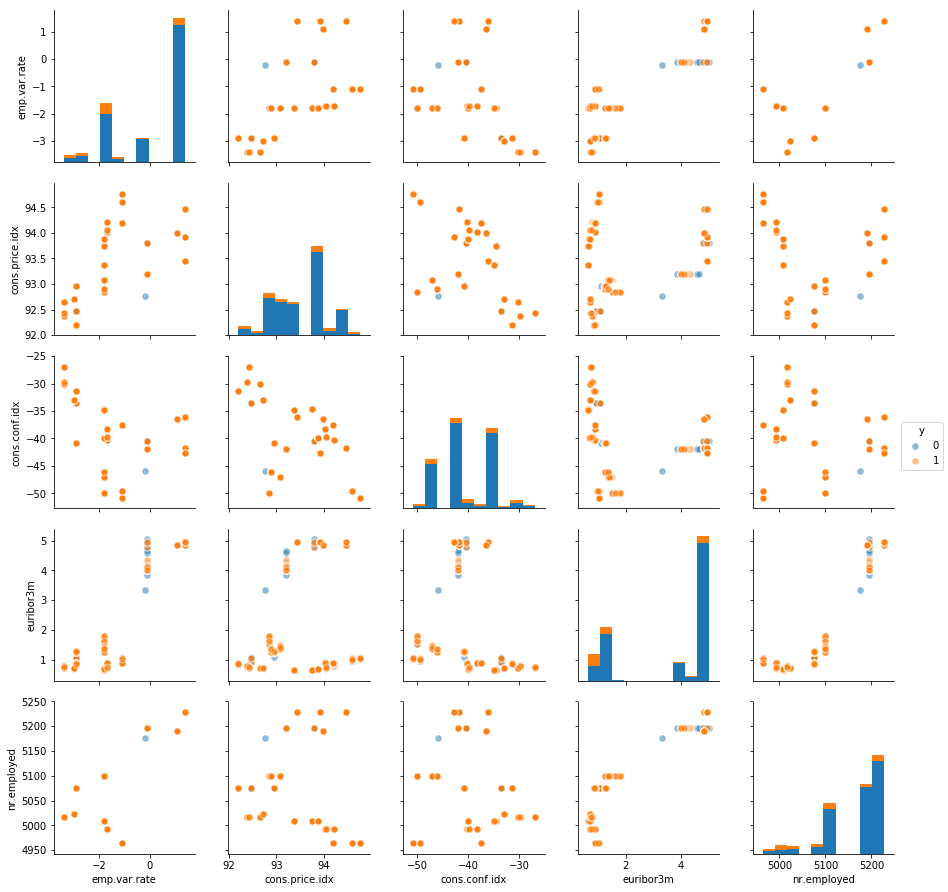

In [25]:
import seaborn as sns
%matplotlib inline

sns.pairplot(bank,
             vars=["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
             plot_kws={"s": 50, "alpha": 0.5},
             hue="y");

Try job, consumer confidence index, and euribor3m

In [26]:
X = pd.get_dummies(bank[["job", "cons.conf.idx", "euribor3m"]], columns=["job"], drop_first=False)
X.drop(["job_admin."], axis=1, inplace=True)
y = bank["y"]

X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

grid = GridSearchCV(LogisticRegression(),
                    param_grid={"penalty": ["l1", "l2"],
                                "C": np.logspace(-4, 2, 7)},
                    scoring="roc_auc",
                    cv=StratifiedKFold(10))

grid.fit(X_train, y_train);

In [27]:
grid.best_score_

0.7539677743700426

In [28]:
grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [29]:
np.mean(cross_val_score(LogisticRegression(C=0.1), X_train, y_train, scoring="roc_auc", cv=10))

0.7539898565989709

Looking better! Let's evaluate both the basic and new model on their respective test sets

In [30]:
y_pred = lr.predict(X_test)
print(roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.5


array([[1087,    0],
       [ 134,    0]])

In [31]:
lr_2 = LogisticRegression(C=0.1)

lr_2.fit(X_train, y_train)

y_pred_2 = lr_2.predict(X_test_2)
print(roc_auc_score(y_test_2, y_pred_2))
confusion_matrix(y_test_2, y_pred_2)

0.5


array([[1059,    0],
       [ 131,    0]])

Turns out that did just as badly on the test set!

We're obviously overfitting somewhere, so that would be the next thing to look at.